## Machine Transaltion with T5

<br>

### Development Envrionment

In [1]:
import json
import fitz
from PIL import Image
from termcolor import colored
from datasets import load_dataset

<br>

### Dataset Information

In [2]:
dataset = load_dataset('./data/iwslt17.de.en')
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 116654
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 888
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 1138
    })
})

<Br>

### Download Baseline Code

In [ ]:
!wget https://github.com/huggingface/transformers/archive/refs/heads/master.zip

[HuggingFace Transformers Official Gihub Repository](https://github.com/huggingface/transformers)

In [ ]:
!pip install ./master.zip

In [ ]:
!unzip master.zip

<br>

### Modify Baseline Code

#### Random Weight Initialization

```   
model = AutoModelForSeq2SeqLM.from_config(
        config=config,
        trust_remote_code=args.trust_remote_code,
    )
``` 

In [5]:
def print_pdf_page(title, load_path, page_num, crop_area):
    
    print(colored(title, attrs=['bold']))
    print()
    
    file_handle = fitz.open(load_path)
    
    if page_num < 10:
        num_path =  "0" + str(page_num + 1)
    elif page_num >= 10:
        num_path =  str(page_num)

    save_path = 'paper_' + num_path + ".png"

    page = file_handle[page_num]
    page_img = page.get_pixmap()
    
    page_img.save(save_path)
    img = Image.open(save_path)
    cropped_img = img.crop(crop_area)
    cropped_img.show()

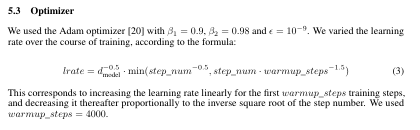

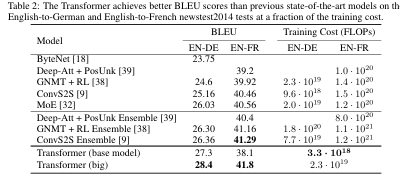

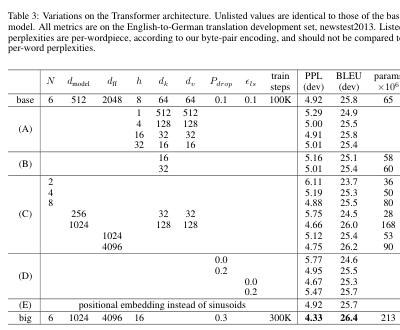

In [11]:
load_path = r"Attention is all you need.pdf"

pdf_list = [['Optimizer', load_path, 6, (100, 500, 520, 630)],
            ['Model Size', load_path, 7, (100, 70, 500, 250)],
            ['Configuration', load_path, 8, (100, 60, 500, 390)],
            ]
for pdf_arg in pdf_list:
    print_pdf_page(pdf_arg[0], pdf_arg[1], pdf_arg[2], pdf_arg[3])

#### Optimizer of Paper

It leads to performance degradation of T5

``` 
training_args.lr_scheduler_type = 'inverse_sqrt'
training_args.adam_beta1 = 0.9
training_args.adam_beta2 = 0.98
training_args.adam_epsilon = 1e-9
```

<br>

#### Metric of Paper

Default Evaluation Metric for T5 is sacrebleu and for Transformer is bleu
<br>Default Evaluation Metric for Transformer is bleu.

``` 
# metric = evaluate.load("sacrebleu", cache_dir=model_args.cache_dir)
metric = evaluate.load("bleu", cache_dir=model_args.cache_dir)
```

<br>

#### Transformer-Big of Paper

T5-Small is same as Transformer-Base
<br>There is no T5-Big
<br>This is configuration for T5-Big same as Transformer-Big

``` 
model.config.d_ff = 4096
model.config.d_model = 1024
model.config.num_heads = 16
model.config.dropout_rate = 0.3
``` 

<br>

In [49]:
!cp run_translation_base_huggingface_example.py transformers-main/examples/pytorch/translation/run_translation.py

In [ ]:
!cp run_translation_big_huggingface_example.py transformers-main/examples/pytorch/translation/run_translation.py

In [17]:
!cp run_translation_no_trainer_base_huggingface_example.py transformers-main/examples/pytorch/translation/run_translation_no_trainer.py

In [ ]:
!cp run_translation_no_trainer_big_huggingface_example.py transformers-main/examples/pytorch/translation/run_translation_no_trainer.py

<br>

### Run Basline Code with Trainer

In [6]:
from huggingface_hub import notebook_login

notebook_login()

In [13]:
import os
os.environ['WANDB_DISABLED'] = 'true'
os.environ["CUDA_DEVICE_ORDER"] ="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

!cp run_translation_base_huggingface_example.py transformers-main/examples/pytorch/translation/run_translation_base.py
!python transformers-main/examples/pytorch/translation/run_translation_base.py \
    --model_name_or_path google-t5/t5-small \
    --do_train \
    --do_eval \
    --do_predict \
    --source_lang de \
    --target_lang en \
    --source_prefix "translate German to English: " \
    --train_file data/iwslt17.de.en/train-de-en.json \
    --validation_file data/iwslt17.de.en/validation-de-en.json \
    --test_file data/iwslt17.de.en/test-de-en.json \
    --output_dir /t5-small-scratch-iwslt2017 \
    --per_device_train_batch_size=64 \
    --per_device_eval_batch_size=128 \
    --overwrite_output_dir \
    --predict_with_generate    

2024-05-11 13:29:20.177673: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 13:29:20.742045: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using custom data configuration default-2098d2201d7f61e4
05/11/2024 13:29:22 - INFO - datasets.builder - Using custom data configuration default-2098d2201d7f61e4
Loading Dataset Infos from /opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/json
05/11/2024 13:29:22 - INFO - datasets.info - Loading Dataset Infos from /opt/conda/lib/python3.10/site-pa

In [ ]:
import os
os.environ['WANDB_DISABLED'] = 'true'
os.environ["CUDA_DEVICE_ORDER"] ="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

!cp run_translation_big_huggingface_example.py transformers-main/examples/pytorch/translation/run_translation_bigger.py
!python transformers-main/examples/pytorch/translation/run_translation_bigger.py \
    --model_name_or_path google-t5/t5-small \
    --do_train \
    --do_eval \
    --do_predict \
    --source_lang de \
    --target_lang en \
    --source_prefix "translate German to English: " \
    --train_file data/iwslt17.de.en/train-de-en.json \
    --validation_file data/iwslt17.de.en/validation-de-en.json \
    --test_file data/iwslt17.de.en/test-de-en.json \
    --output_dir /t5-big-scatch-iwslt2017 \
    --per_device_train_batch_size=32 \
    --per_device_eval_batch_size=64 \
    --overwrite_output_dir \
    --predict_with_generate    

2024-05-12 13:36:54.920763: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 13:36:55.772207: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using custom data configuration default-2098d2201d7f61e4
05/12/2024 13:36:59 - INFO - datasets.builder - Using custom data configuration default-2098d2201d7f61e4
Loading Dataset Infos from /opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/json
05/12/2024 13:36:59 - INFO - datasets.info - Loading Dataset Infos from /opt/conda/lib/python3.10/site-pa

In [ ]:
!wget -O ./t5-small-scratch-iwslt2017/all_results.json https://huggingface.co/minseok0809/t5-small-scratch-iwslt2017/raw/main/all_results.json
!wget -O ./t5-small-scratch-iwslt2017/generated_predictions.csv https://huggingface.co/minseok0809/t5-small-scratch-iwslt2017/raw/main/generated_predictions.csv

In [ ]:
!wget -O ./t5-big-scratch-iwslt2017/all_results.json https://huggingface.co/minseok0809/t5-big-scratch-iwslt2017/raw/main/all_results.json
!wget -O ./t5-big-scratch-iwslt2017/generated_predictions.csv https://huggingface.co/minseok0809/t5-big-scratch-iwslt2017/raw/main/generated_predictions.csv

In [20]:
result_json_path = 't5-small-scratch-iwslt2017/all_results.json'

with open(result_json_path) as f: 
    result_json = json.load(f) 

print("Test Bleu: {}".format(result_json['predict_bleu']))

Test Bleu: 0.1921


In [22]:
result_json_path = 't5-big-scratch-iwslt2017/all_results.json'

with open(result_json_path) as f: 
    result_json = json.load(f) 

print("Test Bleu: {}".format(result_json['predict_bleu']))

Test Bleu: 0.1466


<br>

### Reference

[HuggingFace: Transformers on Translation tasks](https://github.com/huggingface/transformers/tree/main/examples/pytorch/tranlsation)